# CS7643: GPT2 From Scratch & Fine Tuning

# 0. Setup

### [Optional] Set up Google Drive Connection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'cs7643/project'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['project notes.docx', 'Project Proposal.pdf', 'environment.yaml', 'README.md', 'instr_fine_tune', 'data', 'the-verdict.txt', 'model']


In [4]:
import sys
import numpy as np
import math
sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/cs7643/project']

In [6]:
# if running locally set GOOGLE PATH
import sys
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')

Running in google colab. Our path is `/content/drive/MyDrive/cs7643/project`


### Import Modules

In [7]:
!pip install tiktoken

In [8]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [9]:
import torch
print("torch version:", version("torch"))

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")

torch version: 2.6.0+cu124
Using device = cuda


In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
from torch import nn

In [12]:
import pandas as pd

In [13]:
import urllib
from pathlib import Path
import time

# 1. Implement a GPT-2 Model

In [17]:
from model.gpt import GPTModel, text_to_token_ids, token_ids_to_text, generate_text_simple, print_model_stats

In [18]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()  # disable dropout

start_context = "Hello, I am"

tokenizer = tiktoken.get_encoding("gpt2")
encoded_tensor = text_to_token_ids(start_context, tokenizer)

print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
print("\nInput text:", start_context)
print("Encoded input text:", encoded_tensor)
print("encoded_tensor.shape:", encoded_tensor.shape)

out_token_ids = generate_text_simple(
    model=model,
    token_ids=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
decoded_text = token_ids_to_text(out_token_ids, tokenizer)

print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
print("\nOutput:", out_token_ids)
print("Output length:", len(out_token_ids[0]))
print("Output text:", decoded_text)


                      IN

Input text: Hello, I am
Encoded input text: tensor([[15496,    11,   314,   716]])
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Output length: 14
Output text: Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous


In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Total Parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160


In [20]:
print_model_stats(model, "GPT-124M")

Model Name: GPT-124M
	Total Parameters: 163,009,536
	Total Memory Requirement: 621.83 MB


## 2.1 Loading Pre-trained Weights

In [21]:
from transformers import GPT2Model

# Available Models Names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

CHOOSE_MODEL = "gpt2-small (124M)"

gpt_hf = GPT2Model.from_pretrained(model_names[CHOOSE_MODEL], cache_dir="checkpoints")
gpt_hf.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [22]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

## 2.2 Sanity check loaded model

In [23]:
from model.load_model import load_weights

In [24]:
gpt = GPTModel(BASE_CONFIG)
load_weights(gpt, gpt_hf, BASE_CONFIG)

In [25]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=gpt.to(device),
    token_ids=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


# 2. LoRA GPT-2

In [26]:
from model.lora_gpt import LoRALayer, LinearWithLoRA, replace_linear_with_lora

### 2.1 Sanity check LoRA model

In [27]:
lora_gpt = GPTModel(BASE_CONFIG)
load_weights(lora_gpt, gpt_hf, BASE_CONFIG)

In [28]:
total_params = sum(p.numel() for p in lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in lora_gpt.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 163,037,184
Total trainable parameters after: 0


In [29]:
replace_linear_with_lora(lora_gpt, rank=16, alpha=16)

total_params = sum(p.numel() for p in lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 3,470,608


In [30]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=lora_gpt.to(device),
    token_ids=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


# 3. Dataset Loaders

In [14]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

### Test on simple "The Verdict" data

In [15]:
verdict_file_path = GOOGLE_DRIVE_PATH + '/the-verdict.txt'
# verdict_file_path = 'the-verdict.txt'       # If loaded directly to Google Colab Runtime

with open(verdict_file_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [16]:
raw_text

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

# 4. Training Loop

In [24]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [25]:
with open(verdict_file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [26]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [27]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [28]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [29]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [30]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


## 4.1 Compute Loss Helpers

In [31]:
def calc_batch_loss(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)     # Shape: (b, num_tokens)
    logits = model(input_batch)                                                     # Shape: (b, num_tokens, vocab_size)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten())
    return loss

In [32]:
def calc_loader_loss(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_batch_loss(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [33]:
model.to(device)

torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loader_loss(train_loader, model, device)
    val_loss = calc_loader_loss(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


## 4.2 Simple Train loop

In [34]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, token_ids=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print('\t', decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [35]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    model: torch.nn.Module
    train_loader: torch.utils.data.DataLoader
    val_loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    device: torch.device
    num_epochs: int
    eval_freq: int
    eval_iter: int
    start_context: str
    tokenizer: object
    warmup_steps: int = None
    initial_lr: float = 3e-05
    min_lr: float = 1e-6

@dataclass
class TrainingResults:
    train_losses: list
    val_losses: list
    track_tokens_seen: list
    train_perplexity: list
    val_perplexity: list
    track_lrs: list = None

In [36]:
def train_model_simple(config: TrainingConfig):
    train_losses, val_losses, track_tokens_seen = [], [], []
    train_perplexity, val_perplexity = [], []
    tokens_seen, global_step = 0, -1

    # 1) Iterate over training epochs
    for epoch in range(config.num_epochs):
        config.model.train()

        # 2) Iterate over batches
        for input_batch, target_batch in config.train_loader:
            # 3) Reset loss gradients from previous batch iteration
            config.optimizer.zero_grad()

            # 4) Calculate loss on current batch
            loss = calc_batch_loss(input_batch, target_batch, config.model, config.device)

            # 5) Backward pass to calculate loss gradients
            loss.backward()

            # 6) Update model weights using loss gradients
            config.optimizer.step()

            # 7a) Logging
            tokens_seen += input_batch.numel()
            global_step += 1

            # 7b) Optional evaluation step
            if global_step % config.eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    config.model, config.train_loader, config.val_loader, config.device, config.eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_perplexity.append(torch.exp(torch.tensor(train_loss)).item())
                val_perplexity.append(torch.exp(torch.tensor(val_loss)).item())
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 8) Print a sample text after each epoch
        generate_and_print_sample(
            config.model, config.tokenizer, config.device, config.start_context
        )

    return TrainingResults(
        train_losses=train_losses,
        val_losses=val_losses,
        track_tokens_seen=track_tokens_seen,
        train_perplexity=train_perplexity,
        val_perplexity=val_perplexity
    )

### 4.2.1 Sanity check the simple training loop

In [ ]:
torch.manual_seed(123)
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

sanity_check_training_results = train_model_simple(training_config)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(sanity_check_training_results.train_losses))
plot_losses(epochs_tensor,
            sanity_check_training_results.track_tokens_seen,
            sanity_check_training_results.train_losses,
            sanity_check_training_results.val_losses)

## 4.3 Advanced Train Loop

This training loop adds the following to the simple one:

1) Learning rate warmup

2) Cosine decay (after pear l.r has been reached)

3) Gradient clipping

In [ ]:
def train_model(config: TrainingConfig):
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    train_perplexity, val_perplexity = [], []
    tokens_seen, global_step = 0, -1

    # Retrieve the initial l.r from the optimizer, assuming we use it as the peak l.r
    peak_lr = config.optimizer.param_groups[0]["lr"]

    # Calculate the total number of steps in the training process
    total_training_steps = len(config.train_loader) * config.num_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - config.initial_lr) / config.warmup_steps

    # 1) Iterate over training epochs
    for epoch in range(config.num_epochs):
        config.model.train()

        # 2) Iterate over batches
        for input_batch, target_batch in config.train_loader:
            # 3) Reset loss gradients from previous batch iteration
            config.optimizer.zero_grad()
            global_step += 1

            # 4) Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < config.warmup_steps:
                # 4a) Linear warmup
                lr = config.initial_lr + global_step * lr_increment
            else:
                # 4b) Cosine annealing after warmup
                progress = ((global_step - config.warmup_steps) /
                            (total_training_steps - config.warmup_steps))
                lr = config.min_lr + (peak_lr - config.min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
            # 4c) Apply the calculated learning rate to the optimizer
            for param_group in config.optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # 5) Calculate and backpropagate the loss to fill grad
            loss = calc_batch_loss(input_batch, target_batch, config.model, config.device)
            loss.backward()

            # 6) Apply gradient clipping after the warmup phase to avoid exploding gradients
            if global_step >= config.warmup_steps:
                torch.nn.utils.clip_grad_norm_(config.model.parameters(), max_norm=1.0)

            # 7) Update model weights using clipped gradients
            config.optimizer.step()
            tokens_seen += input_batch.numel()

            # 8) Periodically evaluate the model on the training and validation sets
            if global_step % config.eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    config.model, config.train_loader, config.val_loader,
                    config.device, config.eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_perplexity.append(torch.exp(torch.tensor(train_loss)).item())
                val_perplexity.append(torch.exp(torch.tensor(val_loss)).item())
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )

        # 9) Generate and print a sample from the model to monitor progress
        generate_and_print_sample(
            config.model, config.tokenizer, config.device, config.start_context
        )

    return TrainingResults(
        train_losses=train_losses,
        val_losses=val_losses,
        track_tokens_seen=track_tokens_seen,
        train_perplexity=train_perplexity,
        val_perplexity=val_perplexity,
        track_lrs=track_lrs
    )

### 4.3.1 Sanity check the advanced training loop

Typically, the number of warmup steps is between 0.1% to 20% of the total number of steps

In [ ]:
num_epochs = 15
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

27


In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

num_epochs = 15
training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=1,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
)

sanity_check_advanced_training_results = train_model(training_config)

Ep 1 (Iter 000000): Train loss 10.970, Val loss 10.938
Ep 1 (Iter 000005): Train loss 9.336, Val loss 9.460
	 Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.820, Val loss 8.186
Ep 2 (Iter 000015): Train loss 6.344, Val loss 6.892
	 Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.076, Val loss 6.595
Ep 3 (Iter 000025): Train loss 5.681, Val loss 6.771
	 Every effort moves you, the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the
Ep 4 (Iter 000030): Train loss 5.816, Val loss 6.818
Ep 4 (Iter 000035): Train loss 5.776, Val loss 6.863
	 Every effort moves youisisis.                                              
Ep 5 (Iter 000040): Train loss 5.438, Val loss 6.675
	 Every effort moves you.                                                 
Ep 6 (Iter 000045): 

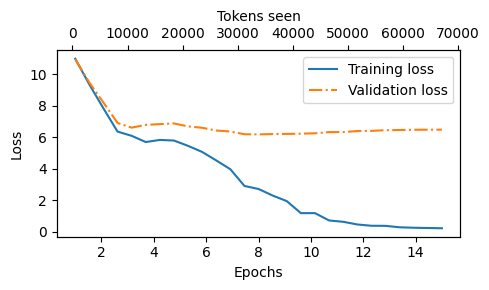

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs_tensor = torch.linspace(1, num_epochs, len(sanity_check_advanced_training_results.train_losses))

plot_losses(epochs_tensor,
            sanity_check_advanced_training_results.track_tokens_seen,
            sanity_check_advanced_training_results.train_losses,
            sanity_check_advanced_training_results.val_losses)
plt.tight_layout(); plt.savefig("3.pdf")
plt.show()

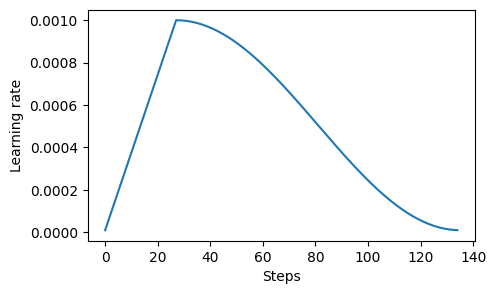

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(sanity_check_advanced_training_results.track_lrs)), sanity_check_advanced_training_results.track_lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

# 5. Instruction Fine Tuning